# Preprocessing, Feature Extraction and Modelling

## Preprocessing

In [1]:
import os
from PIL import Image, ImageOps

# Path to the root directory containing the "CORROSION" and "NOCORROSION" folders
root_dir = './data'

# Define the target size
target_size = (256, 256)

# Output directory for resized images
output_dir = './resize_data'

# Function to resize and add padding to an image
def resize_and_add_padding(image_path, output_path):
    image = Image.open(image_path)
    image = ImageOps.fit(image, target_size, method=0, bleed=0.0, centering=(0.5, 0.5))
    image.save(output_path)

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Iterate through the "CORROSION" and "NOCORROSION" folders
for class_folder in ['CORROSION', 'NOCORROSION']:
    class_dir = os.path.join(root_dir, class_folder)

    # Create a subdirectory in the output directory for each class
    class_output_dir = os.path.join(output_dir, class_folder)
    os.makedirs(class_output_dir, exist_ok=True)

    # Iterate through the images in the class folder
    for filename in os.listdir(class_dir):
        if filename.endswith('.jpg'):  # Adjust the file extension as needed
            input_image_path = os.path.join(class_dir, filename)
            output_image_path = os.path.join(class_output_dir, filename)
            resize_and_add_padding(input_image_path, output_image_path)
            print(f"Resized: {input_image_path} -> {output_image_path}")


FileNotFoundError: [Errno 2] No such file or directory: './data/CORROSION'

## Feature Extraction

### Gray Level Co-Occurance Matrix

In [ ]:
import os
from skimage.feature import graycomatrix, graycoprops
import numpy as np
import pandas as pd
from skimage import io, color, img_as_ubyte

In [ ]:
def compute_glcm_features(image_path):
    img = io.imread(image_path)
    gray = color.rgb2gray(img)
    image = img_as_ubyte(gray)
    
    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128, 144, 160, 176, 192, 208, 224, 240, 255])  # 16-bit
    inds = np.digitize(image, bins)

    max_value = inds.max() + 1
    matrix_cooccurrence = graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=max_value, normed=False, symmetric=False)

    contrast = graycoprops(matrix_cooccurrence, 'contrast')
    dissimilarity = graycoprops(matrix_cooccurrence, 'dissimilarity')
    homogeneity = graycoprops(matrix_cooccurrence, 'homogeneity')
    energy = graycoprops(matrix_cooccurrence, 'energy')
    correlation = graycoprops(matrix_cooccurrence, 'correlation')
    asm = graycoprops(matrix_cooccurrence, 'ASM')

    return {
        "Contrast": contrast,
        "Dissimilarity": dissimilarity,
        "Homogeneity": homogeneity,
        "Energy": energy,
        "Correlation": correlation,
        "ASM": asm
    }

In [ ]:
# Define the paths to your dataset directories
corrosion_dir = "resize_data/CORROSION"
nocorrosion_dir = "resize_data/NOCORROSION"

# Function to compute GLCM features for a directory of images
def compute_glcm_features_for_directory(directory, label):
    features_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg"):  # Modify the file extension as needed
            image_path = os.path.join(directory, filename)
            features = compute_glcm_features(image_path)
            features["Label"] = label  # Add the label
            features_list.append(features)
    return features_list

# Compute GLCM features for both classes
corrosion_features = compute_glcm_features_for_directory(corrosion_dir, "corrosion")
nocorrosion_features = compute_glcm_features_for_directory(nocorrosion_dir, "nocorrosion")

# Combine features for both classes
all_features = corrosion_features + nocorrosion_features

# Create a DataFrame from the features
feature_df = pd.DataFrame(all_features)

# Save the DataFrame to a CSV file
feature_df.to_csv("./features/glcm_features.csv", index=False)


In [ ]:
import pandas as pd

# Read the original DataFrame
df_data = pd.read_csv('./features/glcm_features.csv')

# Extract the 'Contrast' column and remove square brackets
df_data['Contrast'] = df_data['Contrast'].str.replace('[', '').str.replace(']', '')
df_data['Dissimilarity'] = df_data['Dissimilarity'].str.replace('[', '').str.replace(']', '')
df_data['Homogeneity'] = df_data['Homogeneity'].str.replace('[', '').str.replace(']', '')
df_data['Energy'] = df_data['Energy'].str.replace('[', '').str.replace(']', '')
df_data['Correlation'] = df_data['Correlation'].str.replace('[', '').str.replace(']', '')
df_data['ASM'] = df_data['ASM'].str.replace('[', '').str.replace(']', '')



# Split the 'Contrast' column values by whitespace and expand them into separate columns
df_data[['Contrast0', 'Contrast45', 'Contrast90', 'Contrast135']] = df_data['Contrast'].str.split(expand=True)
df_data[['Dissimilarity0', 'Dissimilarity45', 'Dissimilarity90', 'Dissimilarity135']] = df_data['Dissimilarity'].str.split(expand=True)
df_data[['Homogeneity0', 'Homogeneity45', 'Homogeneity90', 'Homogeneity135']] = df_data['Homogeneity'].str.split(expand=True)
df_data[['Energy0', 'Energy45', 'Energy90', 'Energy135']] = df_data['Energy'].str.split(expand=True)
df_data[['Correlation0', 'Correlation45', 'Correlation90', 'Correlation135']] = df_data['Correlation'].str.split(expand=True)
df_data[['ASM0', 'ASM45', 'ASM90', 'ASM135']] = df_data['ASM'].str.split(expand=True)


# Drop the original 'Contrast' column
df_data.drop(columns=['Contrast'], inplace=True)
df_data.drop(columns=['Dissimilarity'], inplace=True)
df_data.drop(columns=['Homogeneity'], inplace=True)
df_data.drop(columns=['Energy'], inplace=True)
df_data.drop(columns=['Correlation'], inplace=True)
df_data.drop(columns=['ASM'], inplace=True)


# Save the new DataFrame to a new CSV file
new_csv_filename = './features/glcm_features_split.csv'
df_data.to_csv(new_csv_filename, index=False)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset (assuming 'glcm_features_new.csv')
data = pd.read_csv('./features/glcm_features_split.csv')

# Extract features and labels
X = data.drop('Label', axis=1)
y = data['Label']

# Encode labels (corrosion, no corrosion) to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the MLP classifier
mlp_classifier = MLPClassifier(hidden_layer_sizes=(300, 50), max_iter=200, random_state=42, verbose=True, solver='adam',alpha=0.0001)
mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = mlp_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")


Iteration 1, loss = 0.68356553
Iteration 2, loss = 0.63372767
Iteration 3, loss = 0.59740192
Iteration 4, loss = 0.56701509
Iteration 5, loss = 0.54424078
Iteration 6, loss = 0.53218771
Iteration 7, loss = 0.52844752
Iteration 8, loss = 0.52346546
Iteration 9, loss = 0.51471134
Iteration 10, loss = 0.51411986
Iteration 11, loss = 0.51764994
Iteration 12, loss = 0.52177556
Iteration 13, loss = 0.51299619
Iteration 14, loss = 0.50841783
Iteration 15, loss = 0.50804045
Iteration 16, loss = 0.49921851
Iteration 17, loss = 0.50053236
Iteration 18, loss = 0.49504968
Iteration 19, loss = 0.49564837
Iteration 20, loss = 0.49414850
Iteration 21, loss = 0.49150638
Iteration 22, loss = 0.49430663
Iteration 23, loss = 0.48933859
Iteration 24, loss = 0.48776358
Iteration 25, loss = 0.48698624
Iteration 26, loss = 0.48447616
Iteration 27, loss = 0.50208853
Iteration 28, loss = 0.49051836
Iteration 29, loss = 0.49822174
Iteration 30, loss = 0.48348168
Iteration 31, loss = 0.48468109
Iteration 32, los

#### Saving The Model

In [ ]:
import joblib

# Save the trained MLP classifier to a file
model_filename = './model/mlp_classifier_model.joblib'
joblib.dump(mlp_classifier, model_filename)

['./model/mlp_classifier_model.joblib']

#### Main Code Prediction

HASIL PREDIKSI: NoCorrosion


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


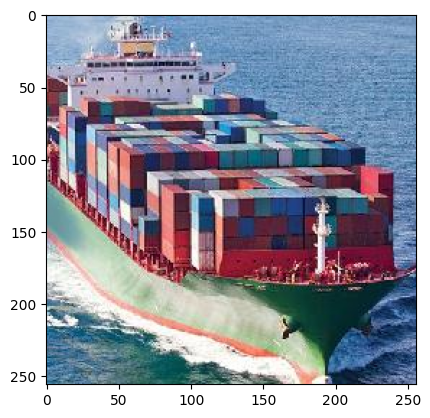

In [ ]:
import joblib
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np

model_filename = './model/mlp_classifier_model.joblib'
loaded_mlp_classifier = joblib.load(model_filename)

# Load the trained MLP classifier model from a filebackup FEATURE/feature_extraction.ipynb
image_path = './resize_data/NOCORROSION/100e35cf19.jpg'
target_size = (256, 256)

image = Image.open(image_path)

# Resize Image
image_new = ImageOps.fit(image, target_size, method=0, bleed=0.0, centering=(0.5, 0.5))
temp_image_path = './temp_resized_image.jpg'
image_new.save(temp_image_path)

# Extract GLCM Value
features = compute_glcm_features(temp_image_path)

# Initialize a new dictionary to store the transformed features
transformed_features = {}

# Define a list of angles
angles = ['0', '45', '90', '135']

# Iterate through the features and angles to create new labels
for feature_name, feature_values in features.items():
    for i, angle in enumerate(angles):
        new_label = f'{feature_name}{angle}'
        transformed_features[new_label] = feature_values[0][i]

# Transform the dictionary to a 1D NumPy array
transformed_features_array = np.array(list(transformed_features.values())).reshape(1, -1)

# Make predictions using the loaded model
predictions = loaded_mlp_classifier.predict(transformed_features_array)

if predictions[0] == 0:
    print("HASIL PREDIKSI: Corrosion")
else:
    print("HASIL PREDIKSI: NoCorrosion")

# Close and remove the temporary image file
image_new.close()
if os.path.exists(temp_image_path):
    os.remove(temp_image_path)

image = plt.imread(image_path)
plt.imshow(image)

### Local Binary Pattern

In [ ]:
def read_images_from_folder(folder_path):
    images = []
    labels = []

    for subfolder in os.listdir(folder_path):
        subfolder_path = os.path.join(folder_path, subfolder)
        if os.path.isdir(subfolder_path):
            label = subfolder  # Use the subfolder name as the label
            for fn in os.listdir(subfolder_path):
                if fn.endswith('.jpg'):
                    img_path = os.path.join(subfolder_path, fn)
                    im = Image.open(img_path).convert('L')
                    data = np.array(im)
                    images.append(data)
                    labels.append(label)

    return images, labels

# Load images and labels from the 'resize_data' folder structure
data_folder = './resize_data'
images, labels = read_images_from_folder(data_folder)
print('Load data success!')

X = np.array(images)
print(X.shape)

# Encode labels (CORROSION, NOCORROSION) to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

radius = 2
n_point = radius * 8

Load data success!
(1819, 256, 256)
(1455, 256, 256)
(364, 256, 256)
(1455,)
(364,)


In [ ]:
def lbp_texture(train_data, test_data):
    max_bins_train = 0
    max_bins_test = 0

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        max_bins_train = max(max_bins_train, int(lbp.max()) + 1)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        max_bins_test = max(max_bins_test, int(lbp.max()) + 1)

    train_hist = np.zeros((len(train_data), max_bins_train))
    test_hist = np.zeros((len(test_data), max_bins_test))

    for i in range(len(train_data)):
        lbp = feature.local_binary_pattern(train_data[i], n_point, radius, 'default')
        train_hist[i], _ = np.histogram(lbp, bins=max_bins_train, density=True)

    for i in range(len(test_data)):
        lbp = feature.local_binary_pattern(test_data[i], n_point, radius, 'default')
        test_hist[i], _ = np.histogram(lbp, bins=max_bins_test, density=True)

    return train_hist, test_hist


In [ ]:
from sklearn.neural_network import MLPClassifier
from skimage import feature
from PIL import Image
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X_train, X_test = lbp_texture(X_train, X_test)

# Create and train an MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=200)
mlp.fit(X_train, y_train)

# Predict on the test set
y_pred = mlp.predict(X_test)

# Evaluate the MLP classifier
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Overall Accuracy: {accuracy}")

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Training Accuracy: 0.970446735395189
Test Accuracy: 0.8351648351648352
Precision: 0.8349485251939739
Recall: 0.8372290951092738
F1 Score: 0.8348457350272234
Overall Accuracy: 0.8351648351648352


In [ ]:
import joblib

# Save the trained MLP model to a file
model_filename = './model/mlp_lbp_model.pkl'
joblib.dump(mlp, model_filename)

print(f"MLP model saved as {model_filename}")

MLP model saved as ./model/mlp_lbp_model.pkl


In [ ]:
from skimage import feature
from PIL import Image
import numpy as np

def lbp_texture(image):
    # Perform LBP feature extraction on a single image
    lbp = feature.local_binary_pattern(image, n_point, radius, 'default')
    max_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, bins=max_bins, density=True)
    return hist

# Load and preprocess a single image
image_path = './resize_data/NOCORROSION/01a5aee1ab.jpg'
im = Image.open(image_path).convert('L')
data = np.array(im)

# Define LBP parameters
radius = 2
n_point = radius * 8

# Call the LBP function on the single image
lbp_features = lbp_texture(data)

loaded_model = joblib.load('model/mlp_lbp_model.pkl')
prediction = loaded_model.predict([lbp_features])
print(prediction)


[1]


### Gray Level Run Length Matrix

In [2]:
import matplotlib.pyplot as plt 
from PIL import Image 
import numpy as np
from itertools import groupby
class getGrayRumatrix:
    data = 0 
    def read_img(self,path=" "):
        
        try:
            img = Image.open(path) 
            img = img.convert('L')
            self.data=np.array(img)
            
        except:
            img = None
            
    def getGrayLevelRumatrix(self, array, theta):
            '''
            
            array: the numpy array of the image
            theta: Input, the angle used when calculating the gray scale run matrix, list type, can contain fields:['deg0', 'deg45', 'deg90', 'deg135']
            glrlm: output,the glrlm result
            '''
            P = array
            x, y = P.shape
            min_pixels = np.min(P)   # the min pixel
            run_length = max(x, y)   # Maximum parade length in pixels
            num_level = np.max(P) - np.min(P) + 1   # Image gray level
    
            deg0 = [val.tolist() for sublist in np.vsplit(P, x) for val in sublist]   # 0deg
            deg90 = [val.tolist() for sublist in np.split(np.transpose(P), y) for val in sublist]   # 90deg
            diags = [P[::-1, :].diagonal(i) for i in range(-P.shape[0]+1, P.shape[1])]   #45deg
            deg45 = [n.tolist() for n in diags]
            Pt = np.rot90(P, 3)   # 135deg
            diags = [Pt[::-1, :].diagonal(i) for i in range(-Pt.shape[0]+1, Pt.shape[1])]
            deg135 = [n.tolist() for n in diags]
    
            def length(l):
                if hasattr(l, '__len__'):
                    return np.size(l)
                else:
                    i = 0
                    for _ in l:
                        i += 1
                    return i
    
            glrlm = np.zeros((num_level, run_length, len(theta)))   
            for angle in theta:
                for splitvec in range(0, len(eval(angle))):
                    flattened = eval(angle)[splitvec]
                    answer = []
                    for key, iter in groupby(flattened):  
                        answer.append((key, length(iter)))   
                    for ansIndex in range(0, len(answer)):
                        glrlm[int(answer[ansIndex][0]-min_pixels), int(answer[ansIndex][1]-1), theta.index(angle)] += 1   
            return glrlm
            
    def apply_over_degree(self,function, x1, x2):
        rows, cols, nums = x1.shape
        result = np.ndarray((rows, cols, nums))
        for i in range(nums):
                #print(x1[:, :, i])
                result[:, :, i] = function(x1[:, :, i], x2)
               # print(result[:, :, i])
                result[result == np.inf] = 0
                result[np.isnan(result)] = 0
        return result 
    def calcuteIJ (self,rlmatrix):
        gray_level, run_length, _ = rlmatrix.shape
        I, J = np.ogrid[0:gray_level, 0:run_length]
        return I, J+1

    def calcuteS(self,rlmatrix):
        return np.apply_over_axes(np.sum, rlmatrix, axes=(0, 1))[0, 0]

    #1.SRE
    def getShortRunEmphasis(self,rlmatrix):
            I, J = self.calcuteIJ(rlmatrix)
            numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, rlmatrix, (J*J)), axes=(0, 1))[0, 0]
            S = self.calcuteS(rlmatrix)
            return numerator / S
    #2.LRE
    def getLongRunEmphasis(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.multiply, rlmatrix, (J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
    #3.GLN
    def getGrayLevelNonUniformity(self,rlmatrix):
        G = np.apply_over_axes(np.sum, rlmatrix, axes=1)
        numerator = np.apply_over_axes(np.sum, (G*G), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
    # 4. RLN
    def getRunLengthNonUniformity(self,rlmatrix):
            R = np.apply_over_axes(np.sum, rlmatrix, axes=0)
            numerator = np.apply_over_axes(np.sum, (R*R), axes=(0, 1))[0, 0]
            S = self.calcuteS(rlmatrix)
            return numerator / S

        # 5. RP
    def getRunPercentage(self,rlmatrix):
            gray_level, run_length,_ = rlmatrix.shape
            num_voxels = gray_level * run_length
            return self.calcuteS(rlmatrix) / num_voxels

        # 6. LGLRE
    def getLowGrayLevelRunEmphasis(self,rlmatrix):
            I, J = self.calcuteIJ(rlmatrix)
            numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, rlmatrix, (I*I)), axes=(0, 1))[0, 0]
            S = self.calcuteS(rlmatrix)
            return numerator / S

        # 7. HGL   
    def getHighGrayLevelRunEmphais(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.multiply, rlmatrix, (I*I)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S

        # 8. SRLGLE
    def getShortRunLowGrayLevelEmphasis(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, rlmatrix, (I*I*J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
    # 9. SRHGLE
    def getShortRunHighGrayLevelEmphasis(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        temp = self.apply_over_degree(np.multiply, rlmatrix, (I*I))
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, temp, (J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
 
    # 10. LRLGLE
    def getLongRunLow(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        temp = self.apply_over_degree(np.multiply, rlmatrix, (J*J))
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.divide, temp, (J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S
 
    # 11. LRHGLE
    def getLongRunHighGrayLevelEmphais(self,rlmatrix):
        I, J = self.calcuteIJ(rlmatrix)
        numerator = np.apply_over_axes(np.sum, self.apply_over_degree(np.multiply, rlmatrix, (I*I*J*J)), axes=(0, 1))[0, 0]
        S = self.calcuteS(rlmatrix)
        return numerator / S

In [3]:
glr_matrix_calculator = getGrayRumatrix()
glr_matrix_calculator.read_img("./resize_data/CORROSION/000001.jpg")

theta = ['deg0', 'deg45', 'deg90', 'deg135']
glrlm_result = glr_matrix_calculator.getGrayLevelRumatrix(glr_matrix_calculator.data, theta)


In [4]:
import os
import csv

root_dir = "./resize_data"
subdirectories = ["CORROSION", "NOCORROSION"]

header = ["Label", "SRE", "LRE", "GLN", "RLN", "RP", "LGLRE", "HGL", "SRLGLE", "SRHGLE", "LRLGLE", "LRHGLE"]

with open("./features/glrlm_image_features.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)

for label, subdirectory in enumerate(subdirectories):
    subdir_path = os.path.join(root_dir, subdirectory)

    for filename in os.listdir(subdir_path):
        if filename.endswith(".jpg"):
            image_path = os.path.join(subdir_path, filename)

            # Read image and calculate GLRLM
            glr_matrix_calculator.read_img(image_path)
            theta = ['deg0', 'deg45', 'deg90', 'deg135']
            glrlm_result = glr_matrix_calculator.getGrayLevelRumatrix(glr_matrix_calculator.data, theta)

            # Calculate features
            sre_result = glr_matrix_calculator.getShortRunEmphasis(glrlm_result)
            lre_result = glr_matrix_calculator.getLongRunEmphasis(glrlm_result)
            gln_result = glr_matrix_calculator.getGrayLevelNonUniformity(glrlm_result)
            rln_result = glr_matrix_calculator.getRunLengthNonUniformity(glrlm_result)
            rp_result = glr_matrix_calculator.getRunPercentage(glrlm_result)
            lglre_result = glr_matrix_calculator.getLowGrayLevelRunEmphasis(glrlm_result)
            hgl_result = glr_matrix_calculator.getHighGrayLevelRunEmphais(glrlm_result)
            srlgle_result = glr_matrix_calculator.getShortRunLowGrayLevelEmphasis(glrlm_result)
            srhgle_result = glr_matrix_calculator.getShortRunHighGrayLevelEmphasis(glrlm_result)
            lrlgle_result = glr_matrix_calculator.getLongRunLow(glrlm_result)
            lrhgle_result = glr_matrix_calculator.getLongRunHighGrayLevelEmphais(glrlm_result)

            # Append results to CSV file
            with open("./features/glrlm_image_features.csv", mode='a', newline='') as file:
                writer = csv.writer(file)
                writer.writerow([label, sre_result, lre_result, gln_result, rln_result, rp_result, lglre_result,
                                hgl_result, srlgle_result, srhgle_result, lrlgle_result, lrhgle_result])


/tmp/ipykernel_4114/699285923.py:63: RuntimeWarning: divide by zero encountered in divide
  result[:, :, i] = function(x1[:, :, i], x2)
/tmp/ipykernel_4114/699285923.py:63: RuntimeWarning: invalid value encountered in divide
  result[:, :, i] = function(x1[:, :, i], x2)


In [6]:
import pandas as pd

df_cek = pd.read_csv('image_features.csv')

# Extract the 'Contrast' column and remove square brackets
df_cek['SRE'] = df_cek['SRE'].str.replace('[', '').str.replace(']', '')
df_cek['LRE'] = df_cek['LRE'].str.replace('[', '').str.replace(']', '')
df_cek['GLN'] = df_cek['GLN'].str.replace('[', '').str.replace(']', '')
df_cek['RLN'] = df_cek['RLN'].str.replace('[', '').str.replace(']', '')
df_cek['RP'] = df_cek['RP'].str.replace('[', '').str.replace(']', '')
df_cek['LGLRE'] = df_cek['LGLRE'].str.replace('[', '').str.replace(']', '')
df_cek['HGL'] = df_cek['HGL'].str.replace('[', '').str.replace(']', '')
df_cek['SRLGLE'] = df_cek['SRLGLE'].str.replace('[', '').str.replace(']', '')
df_cek['SRHGLE'] = df_cek['SRHGLE'].str.replace('[', '').str.replace(']', '')
df_cek['LRLGLE'] = df_cek['LRLGLE'].str.replace('[', '').str.replace(']', '')
df_cek['LRHGLE'] = df_cek['LRHGLE'].str.replace('[', '').str.replace(']', '')


# Split the 'SRE' column values by whitespace and expand them into separate columns
df_cek[['SRE0', 'SRE45', 'SRE90', 'SRE135']] = df_cek['SRE'].str.split(expand=True)
df_cek[['LRE0', 'LRE45', 'LRE90', 'LRE135']] = df_cek['LRE'].str.split(expand=True)
df_cek[['GLN0', 'GLN45', 'GLN90', 'GLN135']] = df_cek['GLN'].str.split(expand=True)
df_cek[['RLN0', 'RLN45', 'RLN90', 'RLN135']] = df_cek['RLN'].str.split(expand=True)
df_cek[['RP0', 'RP45', 'RP90', 'RP135']] = df_cek['RP'].str.split(expand=True)
df_cek[['LGLRE0', 'LGLRE45', 'LGLRE90', 'LGLRE135']] = df_cek['LGLRE'].str.split(expand=True)
df_cek[['HGL0', 'HGL45', 'HGL90', 'HGL135']] = df_cek['HGL'].str.split(expand=True)
df_cek[['SRLGLE0', 'SRLGLE45', 'SRLGLE90', 'SRLGLE135']] = df_cek['SRLGLE'].str.split(expand=True)
df_cek[['SRHGLE0', 'SRHGLE45', 'SRHGLE90', 'SRHGLE135']] = df_cek['SRHGLE'].str.split(expand=True)
df_cek[['LRLGLE0', 'LRLGLE45', 'LRLGLE90', 'LRLGLE135']] = df_cek['LRLGLE'].str.split(expand=True)
df_cek[['LRHGLE0', 'LRHGLE45', 'LRHGLE90', 'LRHGLE135']] = df_cek['LRHGLE'].str.split(expand=True)



# Drop the original 'Contrast' column
df_cek.drop(columns=['SRE'], inplace=True)
df_cek.drop(columns=['LRE'], inplace=True)
df_cek.drop(columns=['GLN'], inplace=True)
df_cek.drop(columns=['RLN'], inplace=True)
df_cek.drop(columns=['RP'], inplace=True)
df_cek.drop(columns=['LGLRE'], inplace=True)
df_cek.drop(columns=['HGL'], inplace=True)
df_cek.drop(columns=['SRLGLE'], inplace=True)
df_cek.drop(columns=['SRHGLE'], inplace=True)
df_cek.drop(columns=['LRLGLE'], inplace=True)
df_cek.drop(columns=['LRHGLE'], inplace=True)



# Save the new DataFrame to a new CSV file
new_csv_filename = './features/glrlm_features_split.csv'
df_cek.to_csv(new_csv_filename, index=False)

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset (assuming 'glcm_features_new.csv')
data = pd.read_csv('./features/glrlm_features_split.csv')

# Extract features and labels
X = data.drop('Label', axis=1)
y = data['Label']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the MLP classifier
glrlm_mlp_classifier = MLPClassifier(hidden_layer_sizes=(300, 100), max_iter=200, random_state=42, verbose=True, solver='adam',alpha=0.00001)
glrlm_mlp_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = glrlm_mlp_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_rep}")


Iteration 1, loss = 18.45534774
Iteration 2, loss = 12.26228164
Iteration 3, loss = 12.48426164
Iteration 4, loss = 14.95910181
Iteration 5, loss = 17.98475946
Iteration 6, loss = 13.39511956
Iteration 7, loss = 14.10097116
Iteration 8, loss = 14.39694533
Iteration 9, loss = 12.66105241
Iteration 10, loss = 15.21206808
Iteration 11, loss = 16.45030558
Iteration 12, loss = 13.36451898
Iteration 13, loss = 12.15098571
Iteration 14, loss = 15.23921058
Iteration 15, loss = 12.13149017
Iteration 16, loss = 14.93899029
Iteration 17, loss = 16.57045006
Iteration 18, loss = 11.41413982
Iteration 19, loss = 13.31894450
Iteration 20, loss = 14.95055581
Iteration 21, loss = 12.08718475
Iteration 22, loss = 17.43075891
Iteration 23, loss = 12.47197227
Iteration 24, loss = 16.36475775
Iteration 25, loss = 11.04131566
Iteration 26, loss = 14.01406083
Iteration 27, loss = 12.13591893
Iteration 28, loss = 19.26789552
Iteration 29, loss = 14.51816861
Iteration 30, loss = 12.02740208
Iteration 31, loss 

In [8]:
import joblib

# Save the trained MLP classifier to a file
model_filename = './model/glrlm_classifier_model.joblib'
joblib.dump(glrlm_mlp_classifier, model_filename)

['./model/glrlm_classifier_model.joblib']

#### Model Use

In [10]:

# Specify range of hyperparameters for MLP models.
params_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.05],
    'hidden_layer_sizes': [(100,50,10), (200,100,50), (500,250,50), (100,), (200,), (300,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant','adaptive'],
}
     

In [11]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

# Create a KFold object with 5 splits.
folds = KFold(n_splits=5, shuffle=True, random_state=0)

# Set the parameters by cross-validation.
# Set up GridSearchCV() funcion.
mlp_model = GridSearchCV(MLPClassifier(), params_grid, scoring='accuracy', cv=folds)
mlp_model.fit(X_train, y_train)

/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  war

CPU times: user 6h 57min 28s, sys: 7h 11min 25s, total: 14h 8min 54s
Wall time: 1h 15min 8s


/home/mizanul/Documents/code/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=MLPClassifier(),
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01, 0.05],
                         'hidden_layer_sizes': [(100, 50, 10), (200, 100, 50),
                                                (500, 250, 50), (100,), (200,),
                                                (300,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']},
             scoring='accuracy')

In [12]:
# Print the accuracy score.
print('Best score for the training data:', mlp_model.best_score_, '\nusing', mlp_model.best_params_)

Best score for the training data: 0.7099656357388315 
using {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (500, 250, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}


### Model Evaluation